# Ruled Based Model
### Hey Together,   
Welcome to the notebook for the ruled based model of commfy.

   
## Part 1: Import libarys

In [237]:
import random
from random import randint
import requests, json
import pandas as pd
from datetime import datetime, timezone
import pytz
import numpy as np
import config
import matplotlib.pyplot as plt
import seaborn as sns

## Part 2: Gather input
There is the option to use the function input_generator() or generate_multi_input(a) whenever you need it.

In [238]:
## auto generated input:
def input_generator():
    location_list=('Atlanta','Berlin','Hamburg','München','Freiburg','Melbourne', 'Moskau') # example list 
    location=location_list[randint(0,6)]
    time=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)##no timezone for better work through
    time=time.replace(hour=randint(time.hour,23))
    heaviness_of_trip=randint(1,3)
    if heaviness_of_trip==1: heaviness_of_trip="easy"
    if heaviness_of_trip==2: heaviness_of_trip="normal"
    if heaviness_of_trip==3: heaviness_of_trip="hard"
    heat_preference=randint(-5,5)
    sex=randint(1,3)
    if sex==1: sex="m"
    if sex==2: sex="f"
    if sex==3: sex="d"
    df=pd.DataFrame({
    "location" : [location],
    "time": [time], 
    "heaviness_of_trip": [heaviness_of_trip], 
    "heat_preference" : [heat_preference],
    "sex": [sex]
    })
    return df

In [239]:
#test input generator
print(input_generator().to_json())
input_generator()

{"location":{"0":"Berlin"},"time":{"0":1642708810925},"heaviness_of_trip":{"0":"easy"},"heat_preference":{"0":5},"sex":{"0":"m"}}


,location,time,heaviness_of_trip,heat_preference,sex
0,Freiburg,2022-01-20 19:00:10.926314,normal,-1,m


In [240]:
#autogenerate DataFrame with multiple input
def generate_multi_input(a):
    df=input_generator()
    for t in range(a-1): #a Trips today (it is asking for one person, so the sex, the heat preference and the ocation ist not changing)
        df=df.append(input_generator(),ignore_index = True)
        df.at[t+1,'location']=df['location'].iloc[0]
        df.at[t+1,'heat_preference']=df['heat_preference'].iloc[0]
        df.at[t+1,'sex']=df['sex'].iloc[0]
    return df

In [266]:
#test data with json input
a=generate_multi_input(4)
print(a)
a=generate_multi_input(4).to_json(orient="index",date_format='iso')
print(a)
json_inp= pd.read_json(a, orient='index',convert_dates=['time'])   
print(json_inp)

  location                       time heaviness_of_trip  heat_preference sex
0  München 2022-01-20 21:01:00.544010              easy                2   m
1  München 2022-01-20 23:01:00.544969              hard                2   m
2  München 2022-01-20 22:01:00.548009              hard                2   m
3  München 2022-01-20 20:01:00.550952              hard                2   m
{"0":{"location":"Atlanta","time":"2022-01-20T21:01:00.554Z","heaviness_of_trip":"hard","heat_preference":1,"sex":"f"},"1":{"location":"Atlanta","time":"2022-01-20T22:01:00.554Z","heaviness_of_trip":"hard","heat_preference":1,"sex":"f"},"2":{"location":"Atlanta","time":"2022-01-20T23:01:00.556Z","heaviness_of_trip":"normal","heat_preference":1,"sex":"f"},"3":{"location":"Atlanta","time":"2022-01-20T20:01:00.558Z","heaviness_of_trip":"hard","heat_preference":1,"sex":"f"}}
  location                             time heaviness_of_trip  \
0  Atlanta 2022-01-20 21:01:00.554000+00:00              hard   
1  Atlant

<hr style="border:2px solid gray"> </hr>   
   
## Part 3: Data cleaning
Go through the Dataframe and check if there is non values or wild data.
1. if heat preference is empty--> 0
2. if sex is empty --> female
3. if time is empty --> now timestamp
4. if heavines of trip is empty --> normal
5. if location is empty --> berlin

<hr style="border:2px solid gray"> </hr>   
   
## Part 4: Further data collection
Weather(df) function to get from location and the time the weather data.

In [242]:
def weather(df):
    # base_url variable to store url
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    future_url="https://api.openweathermap.org/data/2.5/forecast?"
    df['weather']=None
    df['temperature']=None
    #for every row in the pandas:
    for i in range(len(df.index)) :

        # Give city name
        city_name = df['location'].iloc[i]
        df_time=df['time'].iloc[i].replace(tzinfo=None)
        now=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)
        # complete_url variable to store
        # complete url address
        complete_current_url = base_url + "appid=" + config.api_key + "&q=" + city_name + "&units=metric"
        complete_future_url= future_url + "q=" + city_name + "&appid=" + config.api_key + "&units=metric"
        # return response object
        response = requests.get(complete_current_url).json() #response for current time
        response_future = requests.get(complete_future_url).json() # response of weather (in 3 hour timeframes)
        time_forecast=datetime.strptime(response_future['list'][0]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        time_forecast2=datetime.strptime(response_future['list'][1]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        # json method of response object
        # convert json format data into
        # python format data
        if (abs((df_time-now).total_seconds()) <abs((time_forecast-df_time).total_seconds()))&(abs((df_time-now).total_seconds()) <abs((time_forecast2-df_time).total_seconds())): #is the time closer to now then to any of the future forecast
            df.at[i,'weather']=response['weather'][0]['main']
            df.at[i,'temperature']=response['main']['temp']
            df.at[i,'windspeed']=response['wind']['speed']
        else:
            for a in range(10): # looks up to 30 hours in the future
                time_forecast=datetime.strptime(response_future['list'][a]['dt_txt'],'%Y-%m-%d %H:%M:%S')
                substrakt=time_forecast-df_time
                if abs(substrakt.total_seconds())<5400: ## Forecast is just every 3 hours, so it is always taking the closest one
                    df.at[i,'weather']=response_future['list'][a]['weather'][0]['main']
                    df.at[i,'temperature']=response_future['list'][a]['main']['temp']
                    df.at[i,'windspeed']=response_future['list'][a]['wind']['speed']
                    break   
    return df

In [243]:
#weather test
#two dataframes (one with just 1 input, and one with 6 input Trips)
test=weather(input_generator())
len(test.index)
test.to_json()
print(test.to_json())
print(test)
test2=weather(generate_multi_input(20))
test2.head()

{"location":{"0":"Melbourne"},"time":{"0":1642705211189},"heaviness_of_trip":{"0":"easy"},"heat_preference":{"0":2},"sex":{"0":"d"},"weather":{"0":"Clear"},"temperature":{"0":24.58},"windspeed":{"0":1.34}}
    location                       time heaviness_of_trip  heat_preference  \
0  Melbourne 2022-01-20 19:00:11.189611              easy                2   

  sex weather temperature  windspeed  
0   d   Clear       24.58       1.34  


,location,time,heaviness_of_trip,heat_preference,sex,weather,temperature,windspeed
0,Freiburg,2022-01-20 23:00:12.498900,normal,2,f,Snow,-1.1,3.50
1,Freiburg,2022-01-20 23:00:12.499896,normal,2,f,Snow,-1.1,3.50
2,Freiburg,2022-01-20 22:00:12.500897,hard,2,f,Clouds,-0.19,1.99
3,Freiburg,2022-01-20 19:00:12.502856,normal,2,f,Clouds,0.91,1.03
4,Freiburg,2022-01-20 21:00:12.504850,hard,2,f,Clouds,-0.19,1.99


Data visualisation:

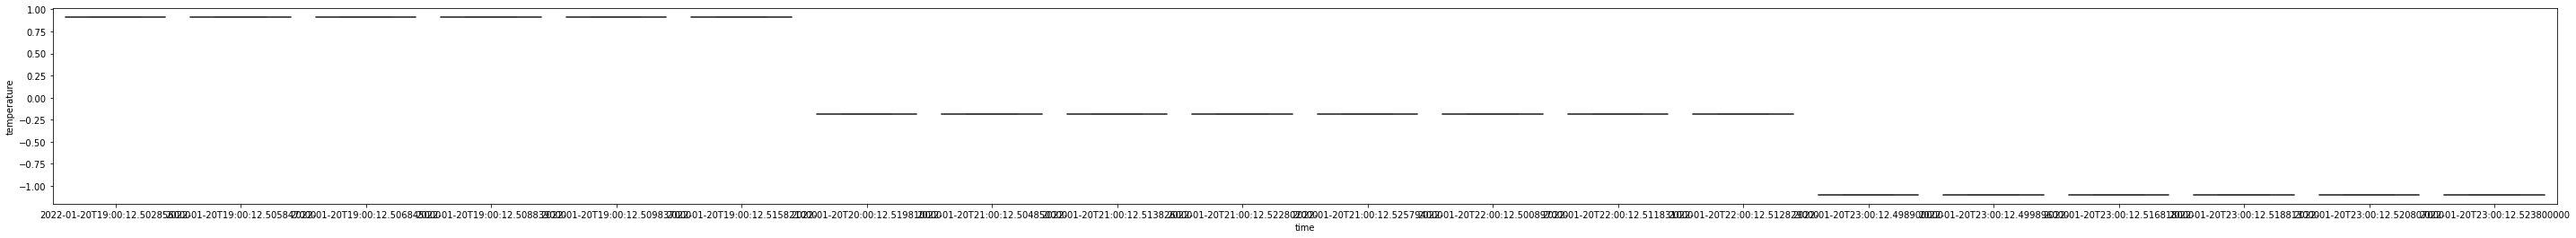

In [244]:
plt.figure(figsize=(50, 4))
a = sns.boxplot(x='time', y='temperature',data=test2.sort_values(by='time'))

Text(0.5, 1.0, 'Scatterplot')

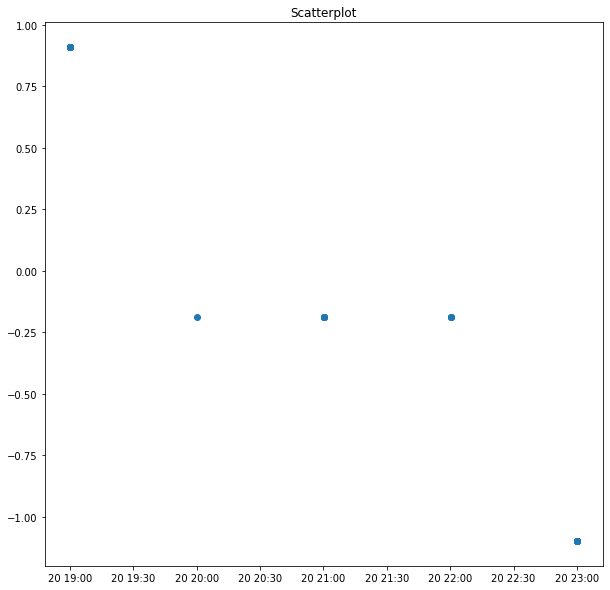

In [245]:
plt.figure(figsize=(10,10))
plt.scatter(x='time', y='temperature',data=test2.sort_values(by='time'))
plt.title("Scatterplot")

<hr style="border:2px solid gray"> </hr>   
   
## Part 5: Define the model
Function add_dummy(df) for test purposes only.<p>
Decision trees defining the output of this model.<p>
All functions have Dataframes as input and add new columns to it and return the bigger Dataframe.

In [246]:
def t_p_s_h(df,i):
    red=0.#reducing parameter
    if df['sex'].iloc[i]=='f':
        red=2.
    heaviness=0.
    if df['heaviness_of_trip'].iloc[i]=='hard':
        heaviness=2.
    else:
        if df['heaviness_of_trip'].iloc[i]=='easy':
            heaviness=-2.
    t_p_s_h=float(df['temperature'].iloc[i])+float(df['heat_preference'].iloc[i])-red+heaviness #t_p_s = temperature_perception and sex and heaviness
    return t_p_s_h

In [247]:
def add_dummy(df):
    df['headwear']=1
    df['sunglasses']=0
    df['neck']=1
    df['singlet']=0
    df['shirt']=0
    df['upper_body_second_layer']=1
    df['upper_body_third_layer']=1
    df['upper_body_outerlayer']=1
    df['hands']=1
    df['raintrousers']=0
    df['socks']=1
    df['shoes']=1
    for i in range(len(df.index)):
        df.at[i,'headwear']=randint(1,4)
        df.at[i,'sunglasses']=randint(0,1)
        df.at[i,'neck']=randint(1,3)
        df.at[i,'singlet']=randint(0,1)
        df.at[i,'shirt']=randint(0,1)
        df.at[i,'upper_body_second_layer']=randint(1,3)
        df.at[i,'upper_body_third_layer']=randint(1,3)
        df.at[i,'upper_body_outerlayer']=randint(1,5)
        df.at[i,'hands']=randint(1,3)
        df.at[i,'raintrousers']=randint(0,1)
        df.at[i,'socks']=randint(1,2)
        df.at[i,'shoes']=randint(1,3)
    return df

In [248]:
##todo implement the logic of the decision tree
##headwear decisiontree
def headwear(df):
   df['headwear']=3
   for i in range(len(df.index)):
      if t_p_s_h(df,i)>10:   # above 10 degrees no headwear beside the helmet
            df.at[i,'headwear']=1
      else:
         if t_p_s_h(df,i)>2:
            df.at[i,'headwear']=2
   return df

In [249]:
## sunglasses decisiontree
def sunglasses(df):
    df['sunglasses']=0
    for i in range(len(df.index)):
        if df['weather'].iloc[i]=='Clear':  # the only split is if it is sunny (clear) or not
            df.at[i,'sunglasses']=1
    return df

In [250]:
## neck decision tree
def neck(df):
    
    df['neck']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # above 22 degrees no buff
            df.at[i,'neck']=1
        else :
            if t_p_s_h(df,i)>15:
                if (df['weather'].iloc[i]=='Rain')|(df['windspeed'].iloc[i]>15): # above 15 degrees and windy or rainy buff, else no buff
                    df.at[i,'neck']=2
                else :
                    df.at[i,'neck']=1
            else :
                if (t_p_s_h(df,i)>0) & (df['weather'].iloc[i]=='Clear'): # above 0 dgrees and sunny bufff and the rest gonna be warm scarf
                    df.at[i,'neck']=2
    return df

In [251]:
##todo implement the logic of the decision tree
##singlet decisiontree
def inner_layer(df):
    df['shirt']=0
    df['singlet']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>10: # at 10 degrees is the split above we wear shirts under we wear a singlet
            df.at[i,'shirt']=1
        else:
            df.at[i,'singlet']=1
    
    return df

In [252]:
##todo implement the logic of the decision tree
##upper_body_second_layer decisiontree
def upper_body_outer_layers(df):
    df['upper_body_second_layer']=3
    df['upper_body_third_layer']=3
    df['upper_body_outer_layer']=5
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>25:
            df.at[i,'upper_body_second_layer']=1
            df.at[i,'upper_body_third_layer']=1
            df.at[i,'upper_body_outer_layer']=1
        else:
            if t_p_s_h(df,i)>20:
                if df['weather'].iloc[i]=='Rain':
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=3
                else:
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=1
            else:
                if t_p_s_h(df,i)>10:
                    if df['weather'].iloc[i]=='Rain':
                        df.at[i,'upper_body_second_layer']=3
                        df.at[i,'upper_body_third_layer']=1
                        df.at[i,'upper_body_outer_layer']=4
                    else:
                        df.at[i,'upper_body_second_layer']=2
                        df.at[i,'upper_body_third_layer']=2
                        df.at[i,'upper_body_outer_layer']=1
                else:
                    if t_p_s_h(df,i)>0:
                        if df['weather'].iloc[i]=='Clear':
                            df.at[i,'upper_body_second_layer']=2
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
                        else:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=1
                            df.at[i,'upper_body_outer_layer']=5
                    else:
                        if t_p_s_h(df,i)>-5:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
    return df

In [253]:
##todo implement the logic of the decision tree
##hands decisiontree
def hands(df):
    df['hands']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>10: # first split at 10 degrees , we recommend no handwear.
            df.at[i,'hands']=1
        else:
            if (t_p_s_h(df,i)>7):
                if(df['windspeed'].iloc[i]>15):
                    df.at[i,'hands']=2
                else:
                    df.at[i,'hands']=1
            else:
                if (t_p_s_h(df,i)>0):
                    df.at[i,'hands']=2
    return df

In [254]:
##todo implement the logic of the decision tree
##raintrousers decisiontree
def raintrousers(df):
    df['raintrousers']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)<17: # first split at 17 degrees , if it is less than 17 and raining we recommend to wear raintrosers.
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'raintrousers']=1
    return df

In [255]:
##todo implement the logic of the decision tree
##socks decisiontree
def socks(df):
    df['socks']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # above 22 and rainy will give socks
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'socks']=2
            else:
                if df['sex'].iloc[i]=='f': # above 22  and no rain and female witout socks for male with socks
                    df.at[i,'socks']=1
                else:
                    df.at[i,'socks']=2
        else:
            if t_p_s_h(df,i)>0:       # above 0 normal socks under 0 warm socks
                df.at[i,'socks']=2
    return df

In [256]:
##todo implement the logic of the decision tree
##shoes decisiontree
def shoes(df):
    df['shoes']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # above 22 degree and rain low shoes
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'shoes']=2
            else:
                    df.at[i,'shoes']=1   #above 22 summer shoes
        else:
            if t_p_s_h(df,i)>7:          # above 7 and rainy --> rainshoes , if not rainy then normal shoes      if under 7 degrees then boots
                if df['weather'].iloc[i]=='Rain':
                    df.at[i,'shoes']=4
                else:
                    df.at[i,'shoes']=2

    return df

In [257]:
##summing up the decision trees into 1 list
def get_clothing_output_rbm(df):
    headwear(df)
    sunglasses(df)
    neck(df)
    inner_layer(df)
    upper_body_outer_layers(df)
    hands(df)
    raintrousers(df)
    socks(df)
    shoes(df)
    #df['control']=0
    #for i in range(len(df.index)):
    #   df.at[i,'control']=t_p_s_h(df,i)
    return df

In [258]:
#test the model
test3=weather(generate_multi_input(20))
get_clothing_output_rbm(test3)

,location,time,heaviness_of_trip,heat_preference,sex,weather,temperature,windspeed,headwear,sunglasses,neck,shirt,singlet,upper_body_second_layer,upper_body_third_layer,upper_body_outer_layer,hands,raintrousers,socks,shoes
0,Moskau,2022-01-20 22:00:19.607353,easy,3,m,Snow,-3.46,5.40,3,0,3,0,1,3,2,3,3,0,3,3
1,Moskau,2022-01-20 23:00:19.607353,easy,3,m,Snow,-4,5.18,3,0,3,0,1,3,2,3,3,0,3,3
2,Moskau,2022-01-20 19:00:19.610356,easy,3,m,Snow,-3.02,6.01,3,0,3,0,1,3,2,3,3,0,3,3
3,Moskau,2022-01-20 20:00:19.617352,hard,3,m,Snow,-3.46,5.40,3,0,3,0,1,3,1,5,2,0,2,3
4,Moskau,2022-01-20 19:00:19.619319,hard,3,m,Snow,-3.02,6.01,3,0,3,0,1,3,1,5,2,0,2,3
5,Moskau,2022-01-20 22:00:19.621333,normal,3,m,Snow,-3.46,5.40,3,0,3,0,1,3,2,3,3,0,3,3
6,Moskau,2022-01-20 22:00:19.623309,hard,3,m,Snow,-3.46,5.40,3,0,3,0,1,3,1,5,2,0,2,3
7,Moskau,2022-01-20 23:00:19.625303,hard,3,m,Snow,-4,5.18,3,0,3,0,1,3,1,5,2,0,2,3
8,Moskau,2022-01-20 22:00:19.629309,hard,3,m,Snow,-3.46,5.40,3,0,3,0,1,3,1,5,2,0,2,3
9,Moskau,2022-01-20 20:00:19.632284,normal,3,m,Snow,-3.46,5.40,3,0,3,0,1,3,2,3,3,0,3,3


In [259]:
add_dummy(test2)

,location,time,heaviness_of_trip,heat_preference,sex,weather,temperature,windspeed,headwear,sunglasses,neck,singlet,shirt,upper_body_second_layer,upper_body_third_layer,upper_body_outerlayer,hands,raintrousers,socks,shoes
0,Freiburg,2022-01-20 23:00:12.498900,normal,2,f,Snow,-1.1,3.50,3,0,3,0,0,1,3,3,3,0,1,3
1,Freiburg,2022-01-20 23:00:12.499896,normal,2,f,Snow,-1.1,3.50,4,0,2,0,1,2,3,2,3,1,1,3
2,Freiburg,2022-01-20 22:00:12.500897,hard,2,f,Clouds,-0.19,1.99,1,1,3,1,1,1,1,5,1,0,1,3
3,Freiburg,2022-01-20 19:00:12.502856,normal,2,f,Clouds,0.91,1.03,1,1,2,0,0,2,3,4,2,0,1,1
4,Freiburg,2022-01-20 21:00:12.504850,hard,2,f,Clouds,-0.19,1.99,1,1,3,1,0,3,2,5,2,0,1,2
5,Freiburg,2022-01-20 19:00:12.505847,easy,2,f,Clouds,0.91,1.03,4,1,1,0,0,3,2,1,3,0,1,1
6,Freiburg,2022-01-20 19:00:12.506845,normal,2,f,Clouds,0.91,1.03,3,1,2,0,1,1,2,4,1,0,1,2
7,Freiburg,2022-01-20 19:00:12.508839,normal,2,f,Clouds,0.91,1.03,1,0,1,1,1,2,1,3,1,0,1,2
8,Freiburg,2022-01-20 19:00:12.509837,hard,2,f,Clouds,0.91,1.03,4,1,3,0,1,1,3,4,1,1,1,2
9,Freiburg,2022-01-20 22:00:12.511831,easy,2,f,Clouds,-0.19,1.99,3,0,1,1,1,3,3,5,1,0,1,2


<hr style="border:2px solid gray"> </hr>  

## Part 6: Model evaluation
How do you evaluate the quality of the decisions? Assume you get true label values.
Which evaluation metrics do you use? Which plots would be interesting?

<hr style="border:2px solid gray"> </hr>  

## Part 7: Output concatenating
get_clothing(df) function to give out 3 Dataframes (one for wearing now, one for the backpack and one what to wear at which trip).<p>
Functions recommendation_df(df) and recommendation_json(js) are translating the input (either from a Dataframe or a Json) into a Json for the Flask API.

In [260]:
# get three lists for to wear now and to bring in the backpack and a full DF what to wear at which trip
def get_clothing(df):
    dic=['headwear','sunglasses','neck','singlet','shirt','upper_body_second_layer','upper_body_third_layer','upper_body_outer_layer','hands','raintrousers','socks','shoes'] # all columns
    oneisnone=['headwear','neck','upper_body_second_layer','upper_body_third_layer','upper_body_outerlayer','hands'] # all colums where 1 is the lowest possible output
    ##wear_now is the first clothing set from the first input beside when shoes and jacket are to big, they have to be wear them 
    wear_now=df.iloc[0:1].copy()
    ##in the backpack is all the other necessary clothes
    backpack_help=df.iloc[:,8:].copy()
    backpack=backpack_help.iloc[0:0].copy() # empty DF with column names
    for i in dic:
        if backpack_help[i].unique().max()==0|((i in oneisnone) & backpack_help[i].unique().max()==1): #if the maximum of the category is not wear any, stop here
            backpack.at[0,i]=None
        else:
            z=0
            while z<backpack_help[i].nunique():
                if backpack_help[i].unique()[z]!=0: #if the the newest item of the category is not to wear any, skip it
                    if ((i in oneisnone) & backpack_help[i].unique()[z]!=1):
                        backpack.at[z,i]=backpack_help[i].unique()[z]
                z=z+1
    ##if shoes or the outerlayer are bigger in the backpack we gonna wear the biggest one, so the backpack won't get to full
    if backpack_help['shoes'].unique().max()> wear_now['shoes'][0]:
        wear_now.at[0,'shoes']=backpack_help['shoes'].unique().max()
    backpack.at[:,'shoes']=None
    if backpack_help['upper_body_outer_layer'].unique().max()> wear_now['upper_body_outer_layer'][0]:
        wear_now.at[0,'upper_body_outer_layer']=backpack_help['upper_body_outer_layer'].unique().max()
    backpack.at[:,'upper_body_outer_layer']=None  
    backpack=backpack.replace({np.nan: None})
    #Ouput of all Clothing Sets in every trip, shoes and outerlayer must be the same as in the first trip
    clothing_per_trip=df
    clothing_per_trip.at[:,'shoes']=wear_now['shoes'][0]
    clothing_per_trip.at[:,'upper_body_outer_layer']=wear_now['upper_body_outer_layer'][0]

    return wear_now, backpack, clothing_per_trip


In [261]:
def recommendation_json(js):
    json_inp= pd.read_json(js, orient='index',convert_dates=['time'])  
    rec_dfs= get_clothing(get_clothing_output_rbm(weather(json_inp)))
    rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
    rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json() # drop the nan from df
    rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
    return rec_js

In [262]:
def recommendation_df(df):
    rec_dfs= get_clothing(get_clothing_output_rbm(weather(df)))
    rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
    rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json()#(orient="columns")
    rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
    return rec_js

In [263]:
recommendation_df(test3)

'{"clothes":{"now":[{"location":"Moskau","time":1642716019607,"heaviness_of_trip":"easy","heat_preference":3,"sex":"m","weather":"Snow","temperature":-3.46,"windspeed":5.4,"headwear":3,"sunglasses":0,"neck":3,"shirt":0,"singlet":1,"upper_body_second_layer":3,"upper_body_third_layer":2,"upper_body_outer_layer":5,"hands":3,"raintrousers":0,"socks":3,"shoes":3}],"backpack":{"0":[{"singlet":1.0,"upper_body_third_layer":2.0,"socks":3.0}],"1":[{"hands":2.0,"socks":2.0}]},"perTrip":{"0":{"location":"Moskau","time":1642716019607,"heaviness_of_trip":"easy","heat_preference":3,"sex":"m","weather":"Snow","temperature":-3.46,"windspeed":5.4,"headwear":3,"sunglasses":0,"neck":3,"shirt":0,"singlet":1,"upper_body_second_layer":3,"upper_body_third_layer":2,"upper_body_outer_layer":5,"hands":3,"raintrousers":0,"socks":3,"shoes":3},"1":{"location":"Moskau","time":1642719619607,"heaviness_of_trip":"easy","heat_preference":3,"sex":"m","weather":"Snow","temperature":-4,"windspeed":5.18,"headwear":3,"sungla

In [267]:
#for testing with json input
print(a)
recommendation_json(a)

{"0":{"location":"Atlanta","time":"2022-01-20T21:01:00.554Z","heaviness_of_trip":"hard","heat_preference":1,"sex":"f"},"1":{"location":"Atlanta","time":"2022-01-20T22:01:00.554Z","heaviness_of_trip":"hard","heat_preference":1,"sex":"f"},"2":{"location":"Atlanta","time":"2022-01-20T23:01:00.556Z","heaviness_of_trip":"normal","heat_preference":1,"sex":"f"},"3":{"location":"Atlanta","time":"2022-01-20T20:01:00.558Z","heaviness_of_trip":"hard","heat_preference":1,"sex":"f"}}


'{"clothes":{"now":[{"location":"Atlanta","time":1642712460554,"heaviness_of_trip":"hard","heat_preference":1,"sex":"f","weather":"Clouds","temperature":5.31,"windspeed":4.75,"headwear":2,"sunglasses":0,"neck":3,"shirt":0,"singlet":1,"upper_body_second_layer":3,"upper_body_third_layer":1,"upper_body_outer_layer":5,"hands":2,"raintrousers":0,"socks":2,"shoes":3}],"backpack":{"0":[{"headwear":2.0,"singlet":1.0,"hands":2.0,"socks":2.0}]},"perTrip":{"0":{"location":"Atlanta","time":1642712460554,"heaviness_of_trip":"hard","heat_preference":1,"sex":"f","weather":"Clouds","temperature":5.31,"windspeed":4.75,"headwear":2,"sunglasses":0,"neck":3,"shirt":0,"singlet":1,"upper_body_second_layer":3,"upper_body_third_layer":1,"upper_body_outer_layer":5,"hands":2,"raintrousers":0,"socks":2,"shoes":3},"1":{"location":"Atlanta","time":1642716060554,"heaviness_of_trip":"hard","heat_preference":1,"sex":"f","weather":"Clouds","temperature":5.31,"windspeed":4.75,"headwear":2,"sunglasses":0,"neck":3,"shirt

In [268]:
#for testing generated input
add_dummy(test2)

,location,time,heaviness_of_trip,heat_preference,sex,weather,temperature,windspeed,headwear,sunglasses,neck,singlet,shirt,upper_body_second_layer,upper_body_third_layer,upper_body_outerlayer,hands,raintrousers,socks,shoes
0,Freiburg,2022-01-20 23:00:12.498900,normal,2,f,Snow,-1.1,3.50,1,0,2,1,0,2,2,5,1,1,2,3
1,Freiburg,2022-01-20 23:00:12.499896,normal,2,f,Snow,-1.1,3.50,3,1,1,0,1,2,1,3,3,1,1,1
2,Freiburg,2022-01-20 22:00:12.500897,hard,2,f,Clouds,-0.19,1.99,2,0,3,1,1,3,2,3,2,1,2,3
3,Freiburg,2022-01-20 19:00:12.502856,normal,2,f,Clouds,0.91,1.03,2,0,2,1,0,1,2,5,3,0,1,3
4,Freiburg,2022-01-20 21:00:12.504850,hard,2,f,Clouds,-0.19,1.99,1,0,1,1,1,1,3,2,1,1,2,1
5,Freiburg,2022-01-20 19:00:12.505847,easy,2,f,Clouds,0.91,1.03,3,1,1,1,0,3,2,2,1,0,1,3
6,Freiburg,2022-01-20 19:00:12.506845,normal,2,f,Clouds,0.91,1.03,1,1,1,1,0,2,1,5,1,0,1,3
7,Freiburg,2022-01-20 19:00:12.508839,normal,2,f,Clouds,0.91,1.03,2,1,1,1,1,2,1,2,3,1,2,3
8,Freiburg,2022-01-20 19:00:12.509837,hard,2,f,Clouds,0.91,1.03,4,1,2,0,1,2,3,3,2,1,2,3
9,Freiburg,2022-01-20 22:00:12.511831,easy,2,f,Clouds,-0.19,1.99,1,0,3,0,1,3,2,2,2,1,2,2


In [269]:
print(get_clothing(test2))

print(get_clothing(test2)[0].to_json(orient="records"))
print(get_clothing(test2)[1].to_json(orient="columns"))
print(get_clothing(test2)[2].to_json(orient="index"))

# res = clothing_per_trip.to_json(orient="records")
#  parsed = json.loads(res)
#   print(json.dumps(parsed,indent=1))

KeyError: 'upper_body_outer_layer'